# Загрузка и анализ данных

In [22]:
from scipy import sparse

In [23]:
train = sparse.load_npz("train.npz")
train

<14590x77888 sparse matrix of type '<class 'numpy.float64'>'
	with 2026769 stored elements in Compressed Sparse Row format>

In [24]:
sparsity = train.nnz / (train.shape[0] * train.shape[1]) * 100

print(f"Заполненность матрицы: {sparsity:.2f}%")
print(f"Данные матрицы: {train.data}")
print(f"Минимальное значение: {train.min()}")
print(f"Максимальное значение: {train.max()}")

Заполненность матрицы: 0.18%
Данные матрицы: [0.14695191 0.1536871  0.16111354 ... 0.03540647 0.02185101 0.02333558]
Минимальное значение: 0.0
Максимальное значение: 0.7475549463482876


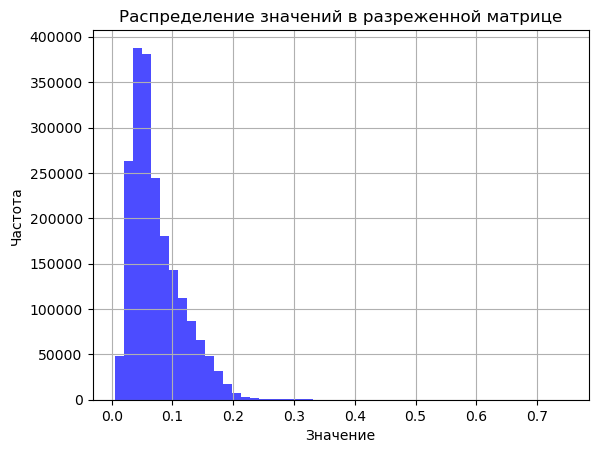

In [25]:
import matplotlib.pyplot as plt

nonzero_values = train.data

# Визуализация распределения значений
plt.hist(nonzero_values, bins=50, color='blue', alpha=0.7)
plt.title('Распределение значений в разреженной матрице')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

In [26]:
# Проверка стат. гипотезы распределения хи-квадрат
from scipy.stats import chisquare

statistic, p_value = chisquare(nonzero_values)

print("Статистика теста:", statistic)
print("p-значение:", p_value)

# Проверим уровень значимости
alpha = 0.05
if p_value > alpha:
    print("Данные похожи на распределение хи-квадрат (не отвергаем нулевую гипотезу)")
else:
    print("Данные не похожи на распределение хи-квадрат (отвергаем нулевую гипотезу)")

Статистика теста: 48967.67345249393
p-значение: 1.0
Данные похожи на распределение хи-квадрат (не отвергаем нулевую гипотезу)


# Понижение размерности

In [27]:
import umap

reducer = umap.UMAP(n_components=2, random_state=42)

embedding = reducer.fit_transform(train)

/home/roman/anaconda3/envs/ML/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


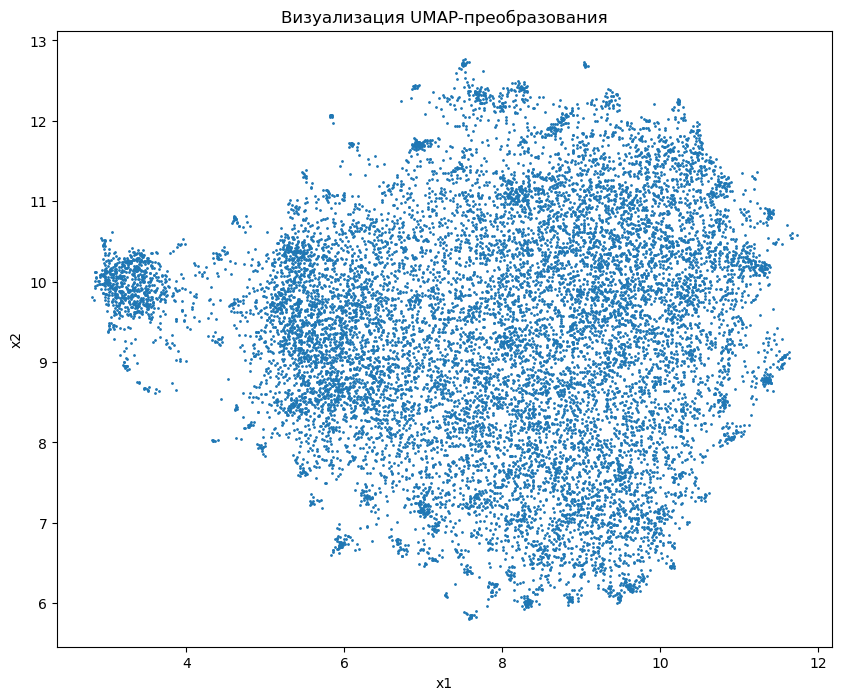

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], s=1)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Визуализация UMAP-преобразования")
plt.show()

# Аггломеративная кластеризация 

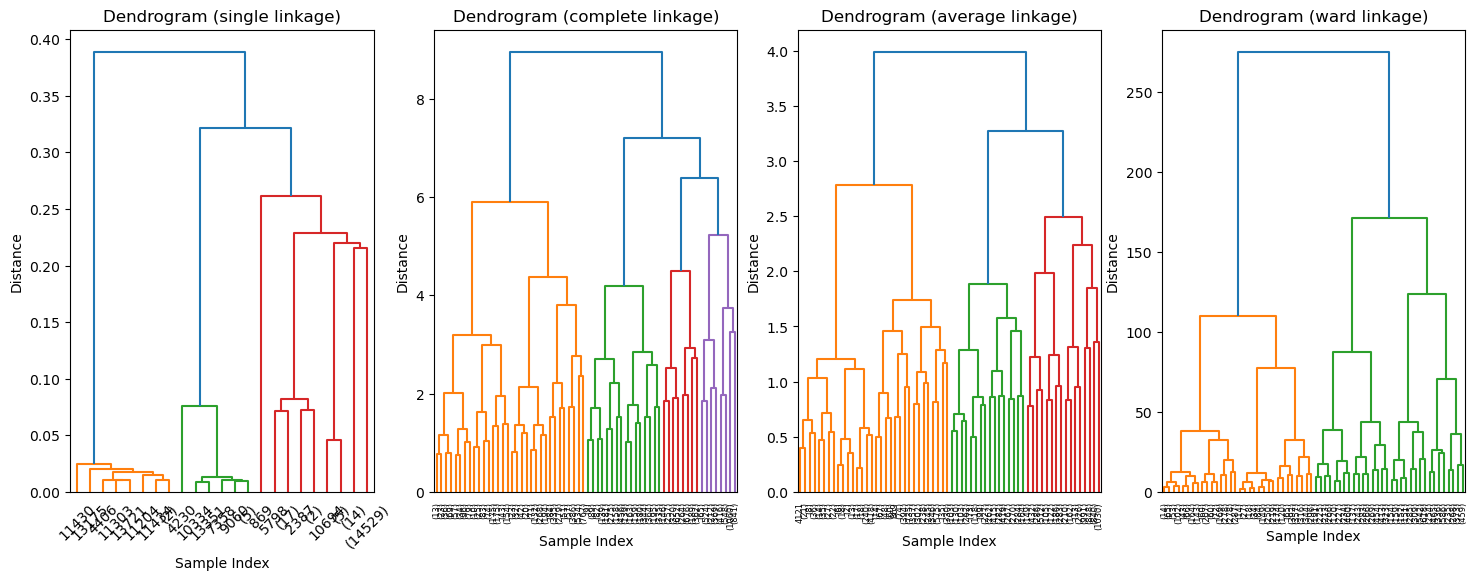

In [31]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram

# Список методов иерархической кластеризации
linkage_methods = ['single', 'complete', 'average', 'ward']

plt.figure(figsize=(18, 6))
for i, linkage_method in enumerate(linkage_methods):
    Z = linkage(embedding, method=linkage_method)
    plt.subplot(1, len(linkage_methods), i+1)
    dendrogram(Z, truncate_mode='level', p=5)
    plt.title(f'Dendrogram ({linkage_method} linkage)')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
plt.show()

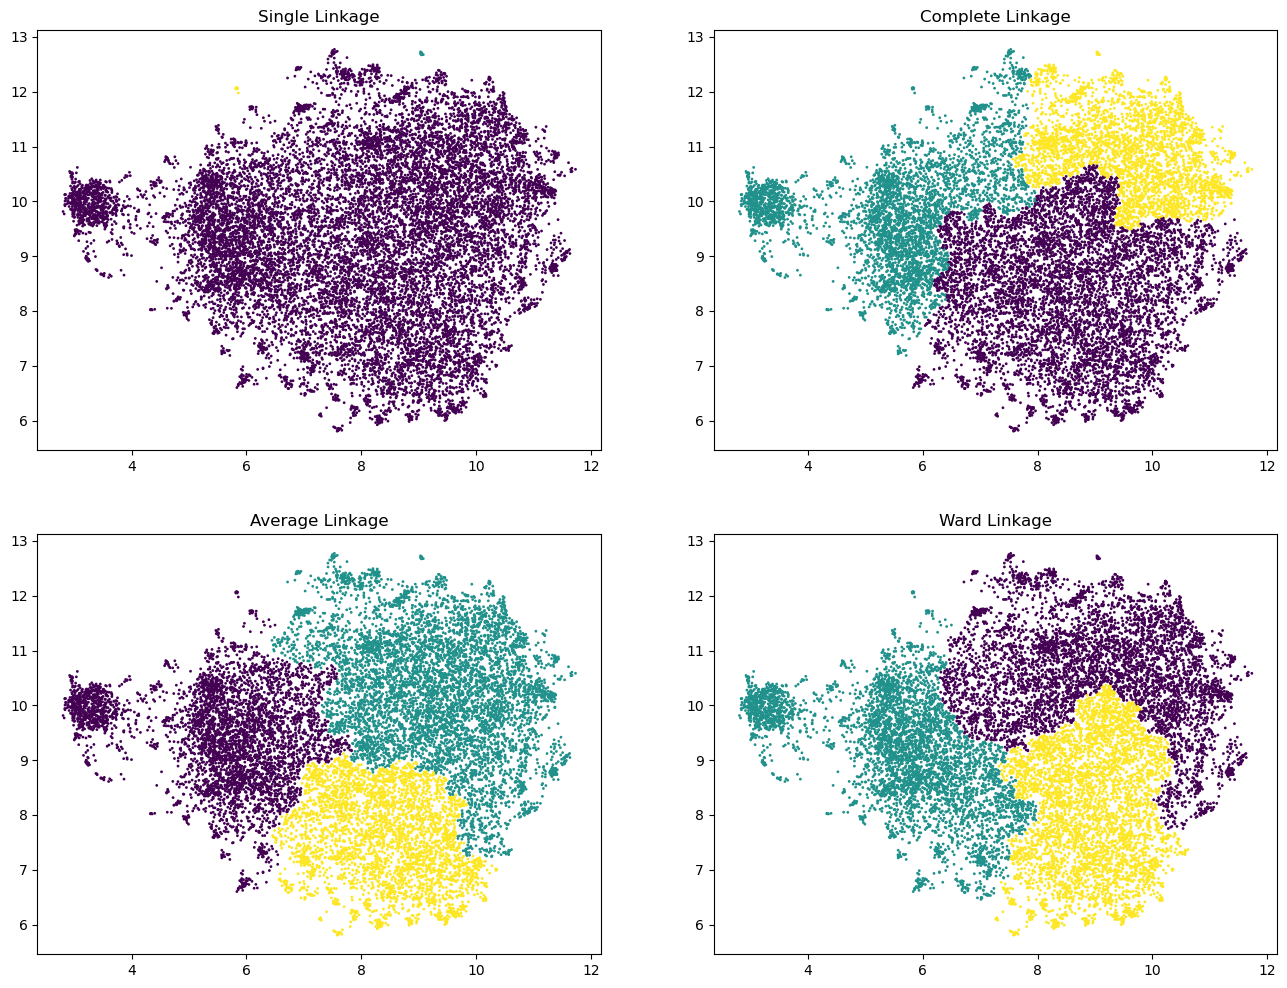

In [32]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

# Список методов иерархической кластеризации
linkage_methods = ['single', 'complete', 'average', 'ward']

plt.figure(figsize=(16, 12)) 

for i, linkage_method in enumerate(linkage_methods, 1):
    clustering = AgglomerativeClustering(linkage=linkage_method, n_clusters=3)
    labels = clustering.fit_predict(embedding)
    
    plt.subplot(2, 2, i)
    plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, s=1)
    plt.title(f'{linkage_method.capitalize()} Linkage')

plt.show()

## Подходящим определили расстояние между центрами кластеров

In [33]:
# Выбор лучшего метода
clustering_average = AgglomerativeClustering(linkage='average', n_clusters=3)
labels_average = clustering_average.fit_predict(embedding)

In [34]:
import pandas as pd

result = pd.DataFrame({'ID': range(len(labels_average)), 'TARGET': labels_average})
result.to_csv('submission.csv', index=False)

## Проанализировав данные в начале, выявили, что они порождены распределением χ2. Попробуем применить кластеризацию Gaussian Mixture


# Gaussian Mixture

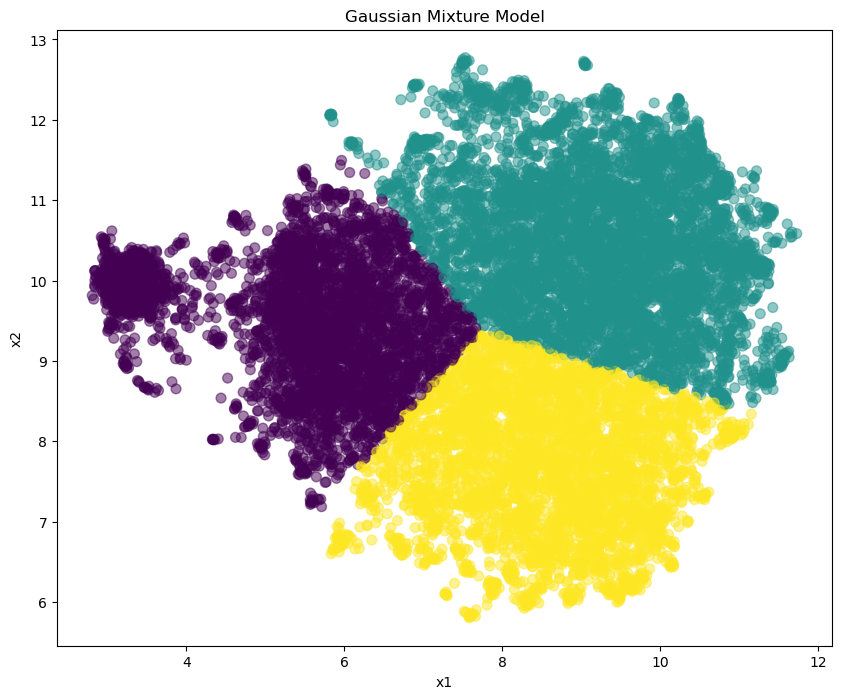

In [35]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

gmm = GaussianMixture(n_components=3, random_state=42, covariance_type='tied', init_params='kmeans')
gmm.fit(embedding)

labels_gmm = gmm.predict(embedding)

plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=labels_gmm, cmap='viridis', s=50, alpha=0.5)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Gaussian Mixture Model")
plt.show()

In [38]:
import pandas as pd

result = pd.DataFrame({'ID': range(len(labels_gmm)), 'TARGET': labels_gmm})

result.to_csv('submission.csv', index=False)